Let's start with Incremental Task Learning. In this scenario, the problem is split into independent tasks. All the tasks have the same target labels. During both inference and training we know to which task each data point belongs.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
N_EXP = 5
TRAIN_MB_SIZE = 128
TRAIN_EPOCHS = 15
EVAL_MB_SIZE = 128
folder = "/content/drive/MyDrive/Colab Notebooks/CL/perf/02_task_incremental"
# the folder in Drive in which store the performance
perf = {} # a dictionary that will contain the performance for all the strategies

In [ ]:
! pip install avalanche-lib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 894.6/894.6 kB 10.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.4/532.4 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 30.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 452.8/452.8 kB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.2/249.2 kB 30.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.8 MB/s eta 0:00:00
  Created wheel for gputil: filename=GPUtil-1.4.0-py3-none-any.whl size=7395 sha256=dac4a457c83da7a61556e0afc8ce4241b809c79736cb8b404ae7714dda45661b
  Stored in directory: /root/.cache/pip/wheels/a9/8a/bd/81082387151853

In [ ]:
from avalanche.benchmarks.classic import SplitCIFAR10
from avalanche.models import SimpleMLP, MTSimpleMLP
from avalanche.training.plugins import EvaluationPlugin
from avalanche.evaluation.metrics import accuracy_metrics,\
    forward_transfer_metrics,bwt_metrics,\
    ram_usage_metrics, timing_metrics, EpochAccuracy
from avalanche.training.plugins import EarlyStoppingPlugin
from torch.nn import CrossEntropyLoss
from torch.optim import SGD
import torch

In [ ]:
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# function that creates the base model (a simple MLP)
def build_model():
  return SimpleMLP(num_classes=2,input_size=32*32*3, hidden_size=512)

# Function that creates the base model with multiple heads.
# The architecture contains the feature extractor that is shared by the tasks.
# Whenever a new task arises, a new head (a task-specific output layer) is
# added with task-specific weights.
# During the inference phase a Multi-Head model requires the task label to
# select the associated head.
def build_model_mt():
  return MTSimpleMLP(input_size=32*32*3, hidden_size=512)

# function that creates the evaluation plugin
# it is used to define the metrics to compute
def build_eval_plugin():
  return EvaluationPlugin(
      accuracy_metrics(experience=True, stream=True),
      # compute the accuracy on each experience's test set and on on the entire
      # test stream
      bwt_metrics(experience=True,stream=True),
      # the same for the backward transfer metric
      forward_transfer_metrics(experience=True,stream=True),
      # the same for the forward transfer metric
      timing_metrics(epoch=True),
      # compute the time metrics during the training phase
      ram_usage_metrics(epoch=True, every=0.001),
      # compute the max ram usage metrics during the training phase,
      # update it every 0.001 seconds
      loggers=[]
      # we do not use loggers, we save the results using the dictionary returned
      # by the train method of the strategy
  )

# function that builds the optimizer given the model
def build_optimizer(model):
  return SGD(model.parameters(), lr=0.001, momentum=0.9)

# function that creates the loss function
def build_criterion():
  return CrossEntropyLoss()

In [ ]:
# utility functions to take the correct keys in the metrics dictionary
def acc_exp_str(exp):
  exp = "{:03d}".format(exp)
  return f'Top1_Acc_Exp/eval_phase/test_stream/Task{exp}/Exp{exp}'

def avg_acc_str(n_exp):
  exp = "{:03d}".format(n_exp-1)
  return f'Top1_Acc_Stream/eval_phase/test_stream/Task{exp}'

def fwt_exp_str(exp):
  exp = "{:03d}".format(exp)
  return f'ExperienceForwardTransfer/eval_phase/test_stream/Task{exp}/Exp{exp}'

def fwt_final_str():
  return "StreamForwardTransfer/eval_phase/test_stream"

def bwt_exp_str(exp):
  exp = "{:03d}".format(exp)
  return f'ExperienceBWT/eval_phase/test_stream/Task{exp}/Exp{exp}'

def bwt_final_str():
  return 'StreamBWT/eval_phase/test_stream'

def memory_final_str(exp):
  exp = "{:03d}".format(exp)
  return f'MaxRAMUsage_Epoch/train_phase/train_stream/Task{exp}'

def time_final_str(exp):
  exp = "{:03d}".format(exp)
  return f'Time_Epoch/train_phase/train_stream/Task{exp}'

In [ ]:
def build_perf(res):
  perf = {}
  perf["accuracies"] = [[r[acc_exp_str(exp)] for exp in range(N_EXP)] for r in res]
  perf["average_accuracy"] = res[-1][avg_acc_str(N_EXP)]
  perf["a_metric"] = np.sum([perf["accuracies"][i][j] for i in range(N_EXP) for j in range(i+1)]) / ((N_EXP)*(N_EXP+1)/2)
  perf["fwt_exp"] = [res[-1][fwt_exp_str(exp)] for exp in range(1,N_EXP)]
  perf["fwt"] = res[-1][fwt_final_str()]
  perf["bwt_exp"] = [[None]*(N_EXP-1)] + [[r[bwt_exp_str(exp)] for exp in range(i+1)] + [None]*(N_EXP-i-2) for i, r in enumerate(res[1:])]
  perf["bwt"] = [r[bwt_final_str()] for r in res]
  perf["time"] = [res[-1][time_final_str(exp)]*TRAIN_EPOCHS for exp in range(N_EXP)]
  perf["time_cum"] = np.cumsum(perf["time"])
  perf["ram"] = [res[-1][memory_final_str(exp)] for exp in range(N_EXP)]
  return perf

In [ ]:
benchmark = SplitCIFAR10(
    n_experiences=N_EXP,
    return_task_id=True,
    class_ids_from_zero_in_each_exp=True,
    seed=42
)

# It istantiates the benchmark.
# In a Task Incremental scenario the task labels must be available.
# Each task has the same class labels.
# Benchmark has two streams: train_stream and test_stream.
# By iterating on each stream we obtain the single experience.

100%|██████████| 170498071/170498071 [00:04<00:00, 34719456.44it/s]


Extracting /root/.avalanche/data/cifar10/cifar-10-python.tar.gz to /root/.avalanche/data/cifar10
Files already downloaded and verified


Print the shape of the data

In [ ]:
for experience in benchmark.train_stream:
  for x, y_label, task_label in experience.dataset:
    break
  print(x.shape, y_label, task_label)

torch.Size([3, 32, 32]) 0 0
torch.Size([3, 32, 32]) 1 1
torch.Size([3, 32, 32]) 0 2
torch.Size([3, 32, 32]) 0 3
torch.Size([3, 32, 32]) 0 4


Naive Strategy

In [ ]:
from avalanche.training.supervised import Naive
strategy_name = "naive"

# create the base learner
model = build_model()

# create the strategy
cl_strategy = Naive(
    model, # the base model
    build_optimizer(model), # the optimizer
    build_criterion(), # the loss function
    train_mb_size=TRAIN_MB_SIZE, # mini-batch size during training
    train_epochs=TRAIN_EPOCHS, # number of training epochs
    eval_mb_size=TRAIN_MB_SIZE, # mini-batch size during the evaluation
    evaluator=build_eval_plugin(), # evaluator plugin
    eval_every=1, # eval every epoch
    plugins=[EarlyStoppingPlugin(patience=2, val_stream_name='train')],
    # we should have used a validation data set
    device=torch.device("cuda")
)

res = [] # list containing the performance after each experience's training
for experience in benchmark.train_stream:
    print("Start of experience ", experience.current_experience)
    print("Current Classes ", experience.classes_in_this_experience)
    print()
    # train returns a dictionary containing all the metric values
    res.append(cl_strategy.train(experience, eval_streams=[benchmark.test_stream]))

# accuracy, fwt and bwt are computed after the training on each experience's
# training set using all the experiences' test sets.
# memory and time are computed after each training epoch and refer
# to the required resources during the training phase. res contains the metrics
# of the last epoch. To compute the total training time we will multiply
# last epoch's metrics by the number of epochs.

# store the performance of the strategy in a custom dictionary
perf[strategy_name] = build_perf(res)

# save the performance in a pkl dictionary
with open(os.path.join(folder, f"perf_{strategy_name}.pkl"), "wb") as f:
  pickle.dump(perf[strategy_name], f)

/usr/local/lib/python3.10/dist-packages/avalanche/training/plugins/evaluation.py:94: UserWarning: No loggers specified, metrics will not be logged
  warnings.warn("No loggers specified, metrics will not be logged")


Start of experience  0
Current Classes  [0, 1]

Start of experience  1
Current Classes  [0, 1]

Start of experience  2
Current Classes  [0, 1]

Start of experience  3
Current Classes  [0, 1]

Start of experience  4
Current Classes  [0, 1]



In [ ]:
res[-1]

{'Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000': 0.418,
 'Top1_Acc_Exp/eval_phase/test_stream/Task001/Exp001': 0.4725,
 'Top1_Acc_Exp/eval_phase/test_stream/Task002/Exp002': 0.374,
 'Top1_Acc_Exp/eval_phase/test_stream/Task003/Exp003': 0.6075,
 'Top1_Acc_Exp/eval_phase/test_stream/Task004/Exp004': 0.792,
 'Top1_Acc_Stream/eval_phase/test_stream/Task004': 0.5328,
 'StreamBWT/eval_phase/test_stream': -0.33887500000000004,
 'StreamForwardTransfer/eval_phase/test_stream': 0.009000000000000036,
 'Time_Epoch/train_phase/train_stream/Task000': 5.789322014999982,
 'MaxRAMUsage_Epoch/train_phase/train_stream/Task000': 1488.109375,
 'ExperienceForwardTransfer/eval_phase/test_stream/Task001/Exp001': -0.14399999999999996,
 'Time_Epoch/train_phase/train_stream/Task001': 7.916252407000002,
 'MaxRAMUsage_Epoch/train_phase/train_stream/Task001': 1489.34375,
 'ExperienceBWT/eval_phase/test_stream/Task000/Exp000': -0.37700000000000006,
 'ExperienceForwardTransfer/eval_phase/test_stream/Task002/Exp

**Accuracy matrix.**

$M_{i,j}$ contains the accuracy, obtained by the model trained after the experience i, computed on the test set of the experience j.

In [ ]:
np.array(perf["naive"]["accuracies"])

array([[0.795 , 0.3935, 0.513 , 0.639 , 0.407 ],
       [0.464 , 0.8405, 0.524 , 0.292 , 0.461 ],
       [0.562 , 0.435 , 0.751 , 0.6045, 0.334 ],
       [0.604 , 0.3135, 0.6265, 0.841 , 0.458 ],
       [0.418 , 0.4725, 0.374 , 0.6075, 0.792 ]])

**Backward Transfer Matrix.**

$M_{i,j}$ contains the difference between:
*   the accuracy, obtained by the final model (the one trained on the i-th experience), computed on the test set of the experience j.
*   the accuracy, obtained by the model trained on the experience j, computed on the test set of the experience j.

It measures how the current model improves or detoriorates the performance on each previous experience.


In [ ]:
np.array(perf["naive"]["bwt_exp"])

array([[None, None, None, None],
       [-0.331, None, None, None],
       [-0.23299999999999998, -0.4055, None, None],
       [-0.19100000000000006, -0.527, -0.12450000000000006, None],
       [-0.37700000000000006, -0.36800000000000005, -0.377,
        -0.23349999999999993]], dtype=object)

**Backward Transfer after each experience.**

The average bwt after the i-th experience's training.

The final bwt will be the one of the last experience.

In [ ]:
perf["naive"]["bwt"]

[0.0, -0.331, -0.31925000000000003, -0.2808333333333334, -0.33887500000000004]

**Forward Transfer after each exprience.**

It contains the difference between:
*   the accuracy, obtained by the random inizialized model, computed on the test set of the experience i+1.
*   the accuracy, obtained by the model trained on the i-th experience, computed on the test set of the experience i+1.

It measures how the current model improves or detoriorates the performance on the next experience with respect to the random inizialized model.

In [ ]:
perf["naive"]["fwt_exp"]

[-0.14399999999999996,
 0.04300000000000004,
 0.15850000000000003,
 -0.021499999999999964]

**Final Forward Transfer metric.**

The average fwt on all the experiences from the first to the penultimate.

In [ ]:
perf["naive"]["fwt"]

0.009000000000000036

**Training Time**

For each experience i it contains the training time. For simplicity, to compute it for each experience, we multiply the last epoch's training time by the number of epochs.

In [ ]:
perf["naive"]["time"]

[86.83983022499973,
 118.74378610500003,
 94.57120921500007,
 113.5854575999997,
 98.20350090000147]

**Cumulative Training Time**

In [ ]:
perf["naive"]["time_cum"]

array([ 86.83983022, 205.58361633, 300.15482554, 413.74028314,
       511.94378405])

**Maximum RAM Usage (Training phase)**

For each experience i, it contains the Maximum amount of RAM used during the training phase. For simplicity, we only consider the last epoch.

In [ ]:
perf["naive"]["ram"]

[1488.109375, 1489.34375, 1489.34765625, 1489.6015625, 1489.60546875]

For each strategy we also build the version that uses a Multi-Head model.

In [ ]:
from avalanche.training.supervised import Naive
strategy_name = "naive_mt"

model = build_model_mt()

cl_strategy = Naive(
    model,
    build_optimizer(model),
    build_criterion(),
    train_mb_size=TRAIN_MB_SIZE,
    train_epochs=TRAIN_EPOCHS,
    eval_mb_size=TRAIN_MB_SIZE,
    evaluator=build_eval_plugin(),
    eval_every=1,
    plugins=[EarlyStoppingPlugin(patience=2, val_stream_name='train')],
    device=torch.device("cuda")
)

res = []
for experience in benchmark.train_stream:
    print("Start of experience ", experience.current_experience)
    print("Current Classes ", experience.classes_in_this_experience)
    print()
    res.append(cl_strategy.train(experience, eval_streams=[benchmark.test_stream]))

perf[strategy_name] = build_perf(res)
with open(os.path.join(folder, f"perf_{strategy_name}.pkl"), "wb") as f:
  pickle.dump(perf[strategy_name], f)

Start of experience  0
Current Classes  [0, 1]

Start of experience  1
Current Classes  [0, 1]

Start of experience  2
Current Classes  [0, 1]

Start of experience  3
Current Classes  [0, 1]

Start of experience  4
Current Classes  [0, 1]



In [ ]:
model

MTSimpleMLP(
  (features): Sequential(
    (0): Linear(in_features=3072, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
  )
  (classifier): MultiHeadClassifier(
    (classifiers): ModuleDict(
      (0): IncrementalClassifier(
        (classifier): Linear(in_features=512, out_features=2, bias=True)
      )
      (1): IncrementalClassifier(
        (classifier): Linear(in_features=512, out_features=2, bias=True)
      )
      (2): IncrementalClassifier(
        (classifier): Linear(in_features=512, out_features=2, bias=True)
      )
      (3): IncrementalClassifier(
        (classifier): Linear(in_features=512, out_features=2, bias=True)
      )
      (4): IncrementalClassifier(
        (classifier): Linear(in_features=512, out_features=2, bias=True)
      )
    )
  )
)

The Multi-Head model has a fature extractor that is shared between the tasks. It has 784 (28x28x1) input features and it outputs 256 features. Then, a new head is crated whenever a new task appears. Each task has its own head (output layer) with its own parameters. During the inference phase the Multi-Head model requires the task label to select the correct head. None of the parameters is frozen.

In [ ]:
print("Feature extractor's parameters:")
for param in model.features.parameters():
  print(param.requires_grad)

print("\nHeads' parameters:")
for param in model.classifier.parameters():
  print(param.requires_grad)

Feature extractor's parameters:
True
True

Heads' parameters:
True
True
True
True
True
True
True
True
True
True


Cumulative

In [ ]:
from avalanche.training.supervised import Cumulative
strategy_name = "cumulative"

model = build_model()
cl_strategy = Cumulative(
    model=model,
    optimizer=build_optimizer(model),
    criterion=build_criterion(),
    train_mb_size=TRAIN_MB_SIZE,
    train_epochs=TRAIN_EPOCHS,
    eval_mb_size=TRAIN_MB_SIZE,
    evaluator=build_eval_plugin(),
    eval_every=1,
    plugins=[EarlyStoppingPlugin(patience=2, val_stream_name='train')],
    device=torch.device("cuda")
)

res = []
for experience in benchmark.train_stream:
    print("Start of experience ", experience.current_experience)
    print("Current Classes ", experience.classes_in_this_experience)
    print()
    res.append(cl_strategy.train(experience, eval_streams=[benchmark.test_stream]))

perf[strategy_name] = build_perf(res)
with open(os.path.join(folder, f"perf_{strategy_name}.pkl"), "wb") as f:
  pickle.dump(perf[strategy_name], f)

Start of experience  0
Current Classes  [0, 1]

Start of experience  1
Current Classes  [0, 1]

Start of experience  2
Current Classes  [0, 1]

Start of experience  3
Current Classes  [0, 1]

Start of experience  4
Current Classes  [0, 1]



In [ ]:
from avalanche.training.supervised import Cumulative
strategy_name = "cumulative_mt"

model = build_model_mt()
cl_strategy = Cumulative(
    model=model,
    optimizer=build_optimizer(model),
    criterion=build_criterion(),
    train_mb_size=TRAIN_MB_SIZE,
    train_epochs=TRAIN_EPOCHS,
    eval_mb_size=TRAIN_MB_SIZE,
    evaluator=build_eval_plugin(),
    eval_every=1,
    plugins=[EarlyStoppingPlugin(patience=2, val_stream_name='train')],
    device=torch.device("cuda")
)

res = []
for experience in benchmark.train_stream:
    print("Start of experience ", experience.current_experience)
    print("Current Classes ", experience.classes_in_this_experience)
    print()
    res.append(cl_strategy.train(experience, eval_streams=[benchmark.test_stream]))

perf[strategy_name] = build_perf(res)
with open(os.path.join(folder, f"perf_{strategy_name}.pkl"), "wb") as f:
  pickle.dump(perf[strategy_name], f)

Start of experience  0
Current Classes  [0, 1]

Start of experience  1
Current Classes  [0, 1]

Start of experience  2
Current Classes  [0, 1]

Start of experience  3
Current Classes  [0, 1]

Start of experience  4
Current Classes  [0, 1]



Replay

In [ ]:
from avalanche.training.supervised import Replay
strategy_name = "replay"

model = build_model()
cl_strategy = Replay(
    model=model,
    optimizer=build_optimizer(model),
    criterion=build_criterion(),
    train_mb_size=TRAIN_MB_SIZE,
    train_epochs=TRAIN_EPOCHS,
    eval_mb_size=TRAIN_MB_SIZE,
    evaluator=build_eval_plugin(),
    eval_every=1,
    plugins=[EarlyStoppingPlugin(patience=2, val_stream_name='train')],
    device=torch.device("cuda")
)

res = []
for experience in benchmark.train_stream:
    print("Start of experience ", experience.current_experience)
    print("Current Classes ", experience.classes_in_this_experience)
    print()
    res.append(cl_strategy.train(experience, eval_streams=[benchmark.test_stream]))

perf[strategy_name] = build_perf(res)
with open(os.path.join(folder, f"perf_{strategy_name}.pkl"), "wb") as f:
  pickle.dump(perf[strategy_name], f)

Start of experience  0
Current Classes  [0, 1]

Start of experience  1
Current Classes  [0, 1]

Start of experience  2
Current Classes  [0, 1]

Start of experience  3
Current Classes  [0, 1]

Start of experience  4
Current Classes  [0, 1]



In [ ]:
from avalanche.training.supervised import Replay
strategy_name = "replay_mt"

model = build_model_mt()
cl_strategy = Replay(
    model=model,
    optimizer=build_optimizer(model),
    criterion=build_criterion(),
    train_mb_size=TRAIN_MB_SIZE,
    train_epochs=TRAIN_EPOCHS,
    eval_mb_size=TRAIN_MB_SIZE,
    evaluator=build_eval_plugin(),
    eval_every=1,
    plugins=[EarlyStoppingPlugin(patience=2, val_stream_name='train')],
    device=torch.device("cuda")
)

res = []
for experience in benchmark.train_stream:
    print("Start of experience ", experience.current_experience)
    print("Current Classes ", experience.classes_in_this_experience)
    print()
    res.append(cl_strategy.train(experience, eval_streams=[benchmark.test_stream]))

perf[strategy_name] = build_perf(res)
with open(os.path.join(folder, f"perf_{strategy_name}.pkl"), "wb") as f:
  pickle.dump(perf[strategy_name], f)

/usr/local/lib/python3.10/dist-packages/avalanche/training/plugins/evaluation.py:94: UserWarning: No loggers specified, metrics will not be logged
  warnings.warn("No loggers specified, metrics will not be logged")


Start of experience  0
Current Classes  [0, 1]

Start of experience  1
Current Classes  [0, 1]

Start of experience  2
Current Classes  [0, 1]

Start of experience  3
Current Classes  [0, 1]

Start of experience  4
Current Classes  [0, 1]



EWC

In [ ]:
from avalanche.training.supervised import EWC
strategy_name = "ewc"

model = build_model()
cl_strategy = EWC(
    model=model,
    ewc_lambda=0.4,
    optimizer=build_optimizer(model),
    criterion=build_criterion(),
    train_mb_size=TRAIN_MB_SIZE,
    train_epochs=TRAIN_EPOCHS,
    eval_mb_size=TRAIN_MB_SIZE,
    evaluator=build_eval_plugin(),
    eval_every=1,
    plugins=[EarlyStoppingPlugin(patience=2, val_stream_name='train')],
    device=torch.device("cuda")
)

res = []
for experience in benchmark.train_stream:
    print("Start of experience ", experience.current_experience)
    print("Current Classes ", experience.classes_in_this_experience)
    print()
    res.append(cl_strategy.train(experience, eval_streams=[benchmark.test_stream]))

perf[strategy_name] = build_perf(res)
with open(os.path.join(folder, f"perf_{strategy_name}.pkl"), "wb") as f:
  pickle.dump(perf[strategy_name], f)

Start of experience  0
Current Classes  [0, 1]

Start of experience  1
Current Classes  [0, 1]

Start of experience  2
Current Classes  [0, 1]

Start of experience  3
Current Classes  [0, 1]

Start of experience  4
Current Classes  [0, 1]



In [ ]:
from avalanche.training.supervised import EWC
strategy_name = "ewc_mt"

model = build_model_mt()
cl_strategy = EWC(
    model=model,
    ewc_lambda=0.4,
    optimizer=build_optimizer(model),
    criterion=build_criterion(),
    train_mb_size=TRAIN_MB_SIZE,
    train_epochs=TRAIN_EPOCHS,
    eval_mb_size=TRAIN_MB_SIZE,
    evaluator=build_eval_plugin(),
    eval_every=1,
    plugins=[EarlyStoppingPlugin(patience=2, val_stream_name='train')],
    device=torch.device("cuda")
)

res = []
for experience in benchmark.train_stream:
    print("Start of experience ", experience.current_experience)
    print("Current Classes ", experience.classes_in_this_experience)
    print()
    res.append(cl_strategy.train(experience, eval_streams=[benchmark.test_stream]))

perf[strategy_name] = build_perf(res)
with open(os.path.join(folder, f"perf_{strategy_name}.pkl"), "wb") as f:
  pickle.dump(perf[strategy_name], f)

Start of experience  0
Current Classes  [0, 1]

Start of experience  1
Current Classes  [0, 1]

Start of experience  2
Current Classes  [0, 1]

Start of experience  3
Current Classes  [0, 1]

Start of experience  4
Current Classes  [0, 1]



LWF

In [ ]:
from avalanche.training.supervised import LwF
strategy_name = "lwf"

model = build_model()
cl_strategy = LwF(
    model=model,
    optimizer=build_optimizer(model),
    criterion=build_criterion(),
    train_mb_size=TRAIN_MB_SIZE,
    train_epochs=TRAIN_EPOCHS,
    eval_mb_size=TRAIN_MB_SIZE,
    evaluator=build_eval_plugin(),
    eval_every=1,
    alpha = 0.3, temperature= 0.5,
    plugins=[EarlyStoppingPlugin(patience=2, val_stream_name='train')],
    device=torch.device("cuda")
)

res = []
for experience in benchmark.train_stream:
    print("Start of experience ", experience.current_experience)
    print("Current Classes ", experience.classes_in_this_experience)
    print()
    res.append(cl_strategy.train(experience, eval_streams=[benchmark.test_stream]))

perf[strategy_name] = build_perf(res)
with open(os.path.join(folder, f"perf_{strategy_name}.pkl"), "wb") as f:
  pickle.dump(perf[strategy_name], f)

Start of experience  0
Current Classes  [0, 1]

Start of experience  1
Current Classes  [0, 1]

Start of experience  2
Current Classes  [0, 1]

Start of experience  3
Current Classes  [0, 1]

Start of experience  4
Current Classes  [0, 1]



In [ ]:
from avalanche.training.supervised import LwF
strategy_name = "lwf_mt"

model = build_model_mt()
cl_strategy = LwF(
    model=model,
    optimizer=build_optimizer(model),
    criterion=build_criterion(),
    train_mb_size=TRAIN_MB_SIZE,
    train_epochs=TRAIN_EPOCHS,
    eval_mb_size=TRAIN_MB_SIZE,
    evaluator=build_eval_plugin(),
    eval_every=1,
    alpha = 0.3, temperature= 0.5,
    plugins=[EarlyStoppingPlugin(patience=2, val_stream_name='train')],
    device=torch.device("cuda")
)

res = []
for experience in benchmark.train_stream:
    print("Start of experience ", experience.current_experience)
    print("Current Classes ", experience.classes_in_this_experience)
    print()
    res.append(cl_strategy.train(experience, eval_streams=[benchmark.test_stream]))

perf[strategy_name] = build_perf(res)
with open(os.path.join(folder, f"perf_{strategy_name}.pkl"), "wb") as f:
  pickle.dump(perf[strategy_name], f)

Start of experience  0
Current Classes  [0, 1]

Start of experience  1
Current Classes  [0, 1]

Start of experience  2
Current Classes  [0, 1]

Start of experience  3
Current Classes  [0, 1]

Start of experience  4
Current Classes  [0, 1]



PNN

In [ ]:
from avalanche.training.supervised import PNNStrategy
from avalanche.models import PNN

strategy_name = "pnn"

model = PNN(in_features=32*32*3, hidden_features_per_column=512)

cl_strategy = PNNStrategy(
    model=model,
    optimizer=build_optimizer(model),
    criterion=build_criterion(),
    train_mb_size=TRAIN_MB_SIZE,
    train_epochs=TRAIN_EPOCHS,
    eval_mb_size=TRAIN_MB_SIZE,
    evaluator=build_eval_plugin(),
    eval_every=1,
    plugins=[EarlyStoppingPlugin(patience=2, val_stream_name='train')],
    device=torch.device("cuda")
)

res = []
for experience in benchmark.train_stream:
    print("Start of experience ", experience.current_experience)
    print("Current Classes ", experience.classes_in_this_experience)
    print()
    res.append(cl_strategy.train(experience, eval_streams=[benchmark.test_stream]))

perf[strategy_name] = build_perf(res)
with open(os.path.join(folder, f"perf_{strategy_name}.pkl"), "wb") as f:
  pickle.dump(perf[strategy_name], f)

Start of experience  0
Current Classes  [0, 1]

Start of experience  1
Current Classes  [0, 1]

Start of experience  2
Current Classes  [0, 1]

Start of experience  3
Current Classes  [0, 1]

Start of experience  4
Current Classes  [0, 1]



GEM (Replay + Regularization)

In [ ]:
from avalanche.training.supervised import GEM

strategy_name = "gem"

model = build_model()

cl_strategy = GEM(
    model=model,
    optimizer=build_optimizer(model),
    criterion=build_criterion(),
    train_mb_size=TRAIN_MB_SIZE,
    train_epochs=TRAIN_EPOCHS,
    eval_mb_size=TRAIN_MB_SIZE,
    evaluator=build_eval_plugin(),
    eval_every=1,
    patterns_per_exp = 100,
    plugins=[EarlyStoppingPlugin(patience=2, val_stream_name='train')],
    device=torch.device("cuda")
)

res = []
for experience in benchmark.train_stream:
    print("Start of experience ", experience.current_experience)
    print("Current Classes ", experience.classes_in_this_experience)
    print()
    res.append(cl_strategy.train(experience, eval_streams=[benchmark.test_stream]))

perf[strategy_name] = build_perf(res)
with open(os.path.join(folder, f"perf_{strategy_name}.pkl"), "wb") as f:
  pickle.dump(perf[strategy_name], f)

Start of experience  0
Current Classes  [0, 1]

Start of experience  1
Current Classes  [0, 1]

Start of experience  2
Current Classes  [0, 1]

Start of experience  3
Current Classes  [0, 1]

Start of experience  4
Current Classes  [0, 1]



In [ ]:
from avalanche.training.supervised import GEM

strategy_name = "gem_mt"

model = build_model_mt()

cl_strategy = GEM(
    model=model,
    optimizer=build_optimizer(model),
    criterion=build_criterion(),
    train_mb_size=TRAIN_MB_SIZE,
    train_epochs=TRAIN_EPOCHS,
    eval_mb_size=TRAIN_MB_SIZE,
    evaluator=build_eval_plugin(),
    eval_every=1,
    patterns_per_exp = 100,
    plugins=[EarlyStoppingPlugin(patience=2, val_stream_name='train')],
    device=torch.device("cuda")
)

res = []
for experience in benchmark.train_stream:
    print("Start of experience ", experience.current_experience)
    print("Current Classes ", experience.classes_in_this_experience)
    print()
    res.append(cl_strategy.train(experience, eval_streams=[benchmark.test_stream]))

perf[strategy_name] = build_perf(res)
with open(os.path.join(folder, f"perf_{strategy_name}.pkl"), "wb") as f:
  pickle.dump(perf[strategy_name], f)

Start of experience  0
Current Classes  [0, 1]

Start of experience  1
Current Classes  [0, 1]

Start of experience  2
Current Classes  [0, 1]

Start of experience  3
Current Classes  [0, 1]

Start of experience  4
Current Classes  [0, 1]



# Plot performance

In [ ]:
strategies = ["naive", "naive_mt", "cumulative", "cumulative_mt", "replay", "replay_mt", "ewc", "ewc_mt", "lwf", "lwf_mt", "pnn", "gem", "gem_mt"]
perf = {}
for strategy_name in strategies:
  with open(os.path.join(folder, f"perf_{strategy_name}.pkl"), "rb") as f:
    perf[strategy_name] = pickle.load(f)

Let's analyze the usage of multiple heads.

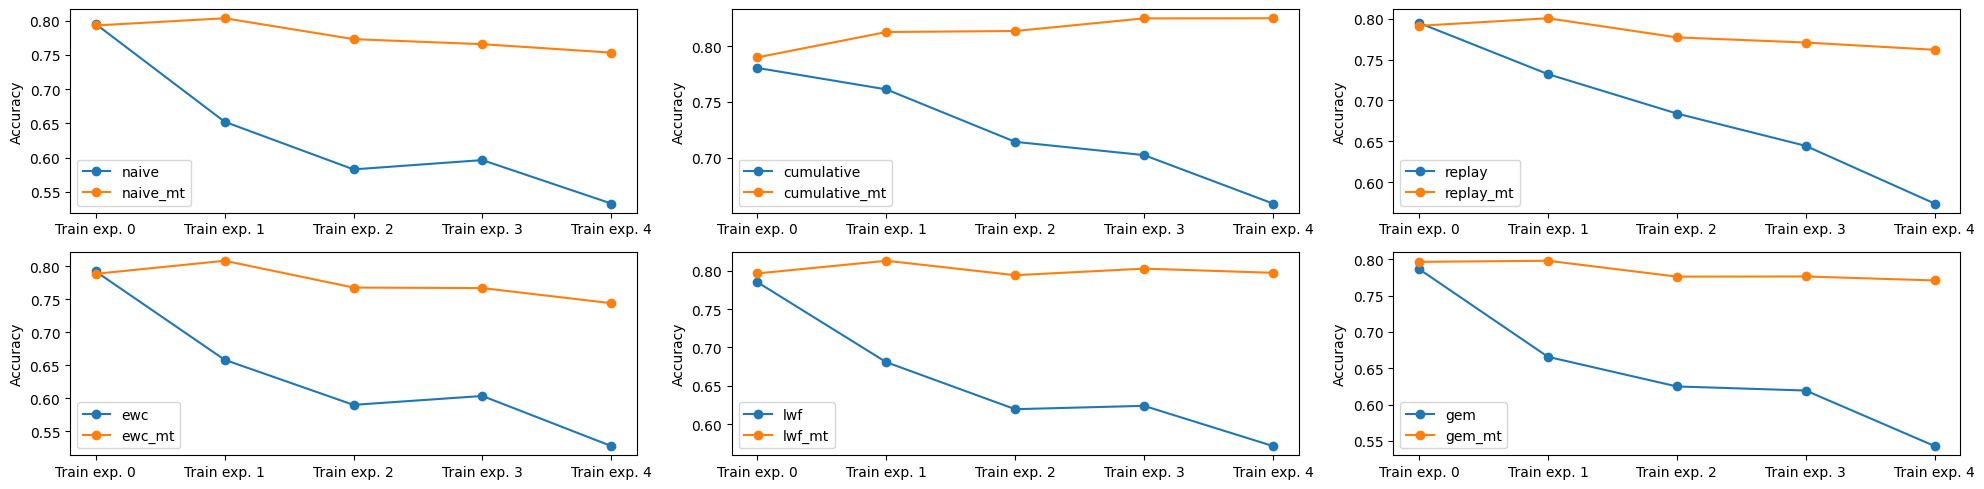

In [ ]:
fig, ax = plt.subplots(figsize=(20,5), nrows=2, ncols=3, sharey=False)
ax = [ax[i][j] for i in range(len(ax)) for j in range(len(ax[i]))]
for i, strategy_name in enumerate(["naive", "cumulative", "replay", "ewc", "lwf", "gem"]):
  for strategy in [strategy_name, strategy_name+"_mt"]:
    accs = [np.mean(perf[strategy]["accuracies"][i][:i+1]) for i in range(len(perf[strategy]["accuracies"]))]
    ax[i].plot(accs, label=strategy, marker="o")
for i in range(len(ax)):
  ax[i].set_xticks(ticks=np.arange(len(accs)), labels=[f"Train exp. {i}" for i in range(N_EXP)])
  ax[i].set_ylabel("Accuracy")
  ax[i].legend()
plt.tight_layout()

The usage of the multiple heads significantly reduces the catastrophic forgetting. Let's keep only the Multi-Head version of each strategy.

In [ ]:
for strategy in strategies:
  if "naive" not in strategy and strategy.endswith("_mt"):
    if perf[strategy.replace("_mt", "")]["average_accuracy"] < perf[strategy]["average_accuracy"]:
      del perf[strategy.replace("_mt", "")]
    else:
      del perf[strategy]
strategies = list(perf.keys())

Accuracies

In [ ]:
def plot_strategy_accs(strategy, perf, ax):
  train_exp = [f"Train exp {i}" for i in range(N_EXP)]
  accs = np.array(perf[strategy]["accuracies"])
  values = {f'Test exp. {i}': accs[:,i] for i in range(N_EXP)}

  cmap = plt.cm.Blues
  x = np.arange(len(train_exp))  # the label locations
  width = 0.15  # the width of the bars
  multiplier = 0

  i = 0
  for attribute, measurement in values.items():
      color = cmap((i+1)*(1/(len(values)+1)))
      offset = width * multiplier
      rects = ax.bar(x + offset, measurement, width, label=attribute, color=color)
      multiplier += 1
      i += 1

  # Add some text for labels, title and custom x-axis tick labels, etc.
  ax.set_ylabel('Accuracy')
  ax.set_xticks(x + 1.5*width, train_exp)
  ax.legend(bbox_to_anchor=(1,1), loc="upper left")
  ax.set_title(strategy.capitalize())

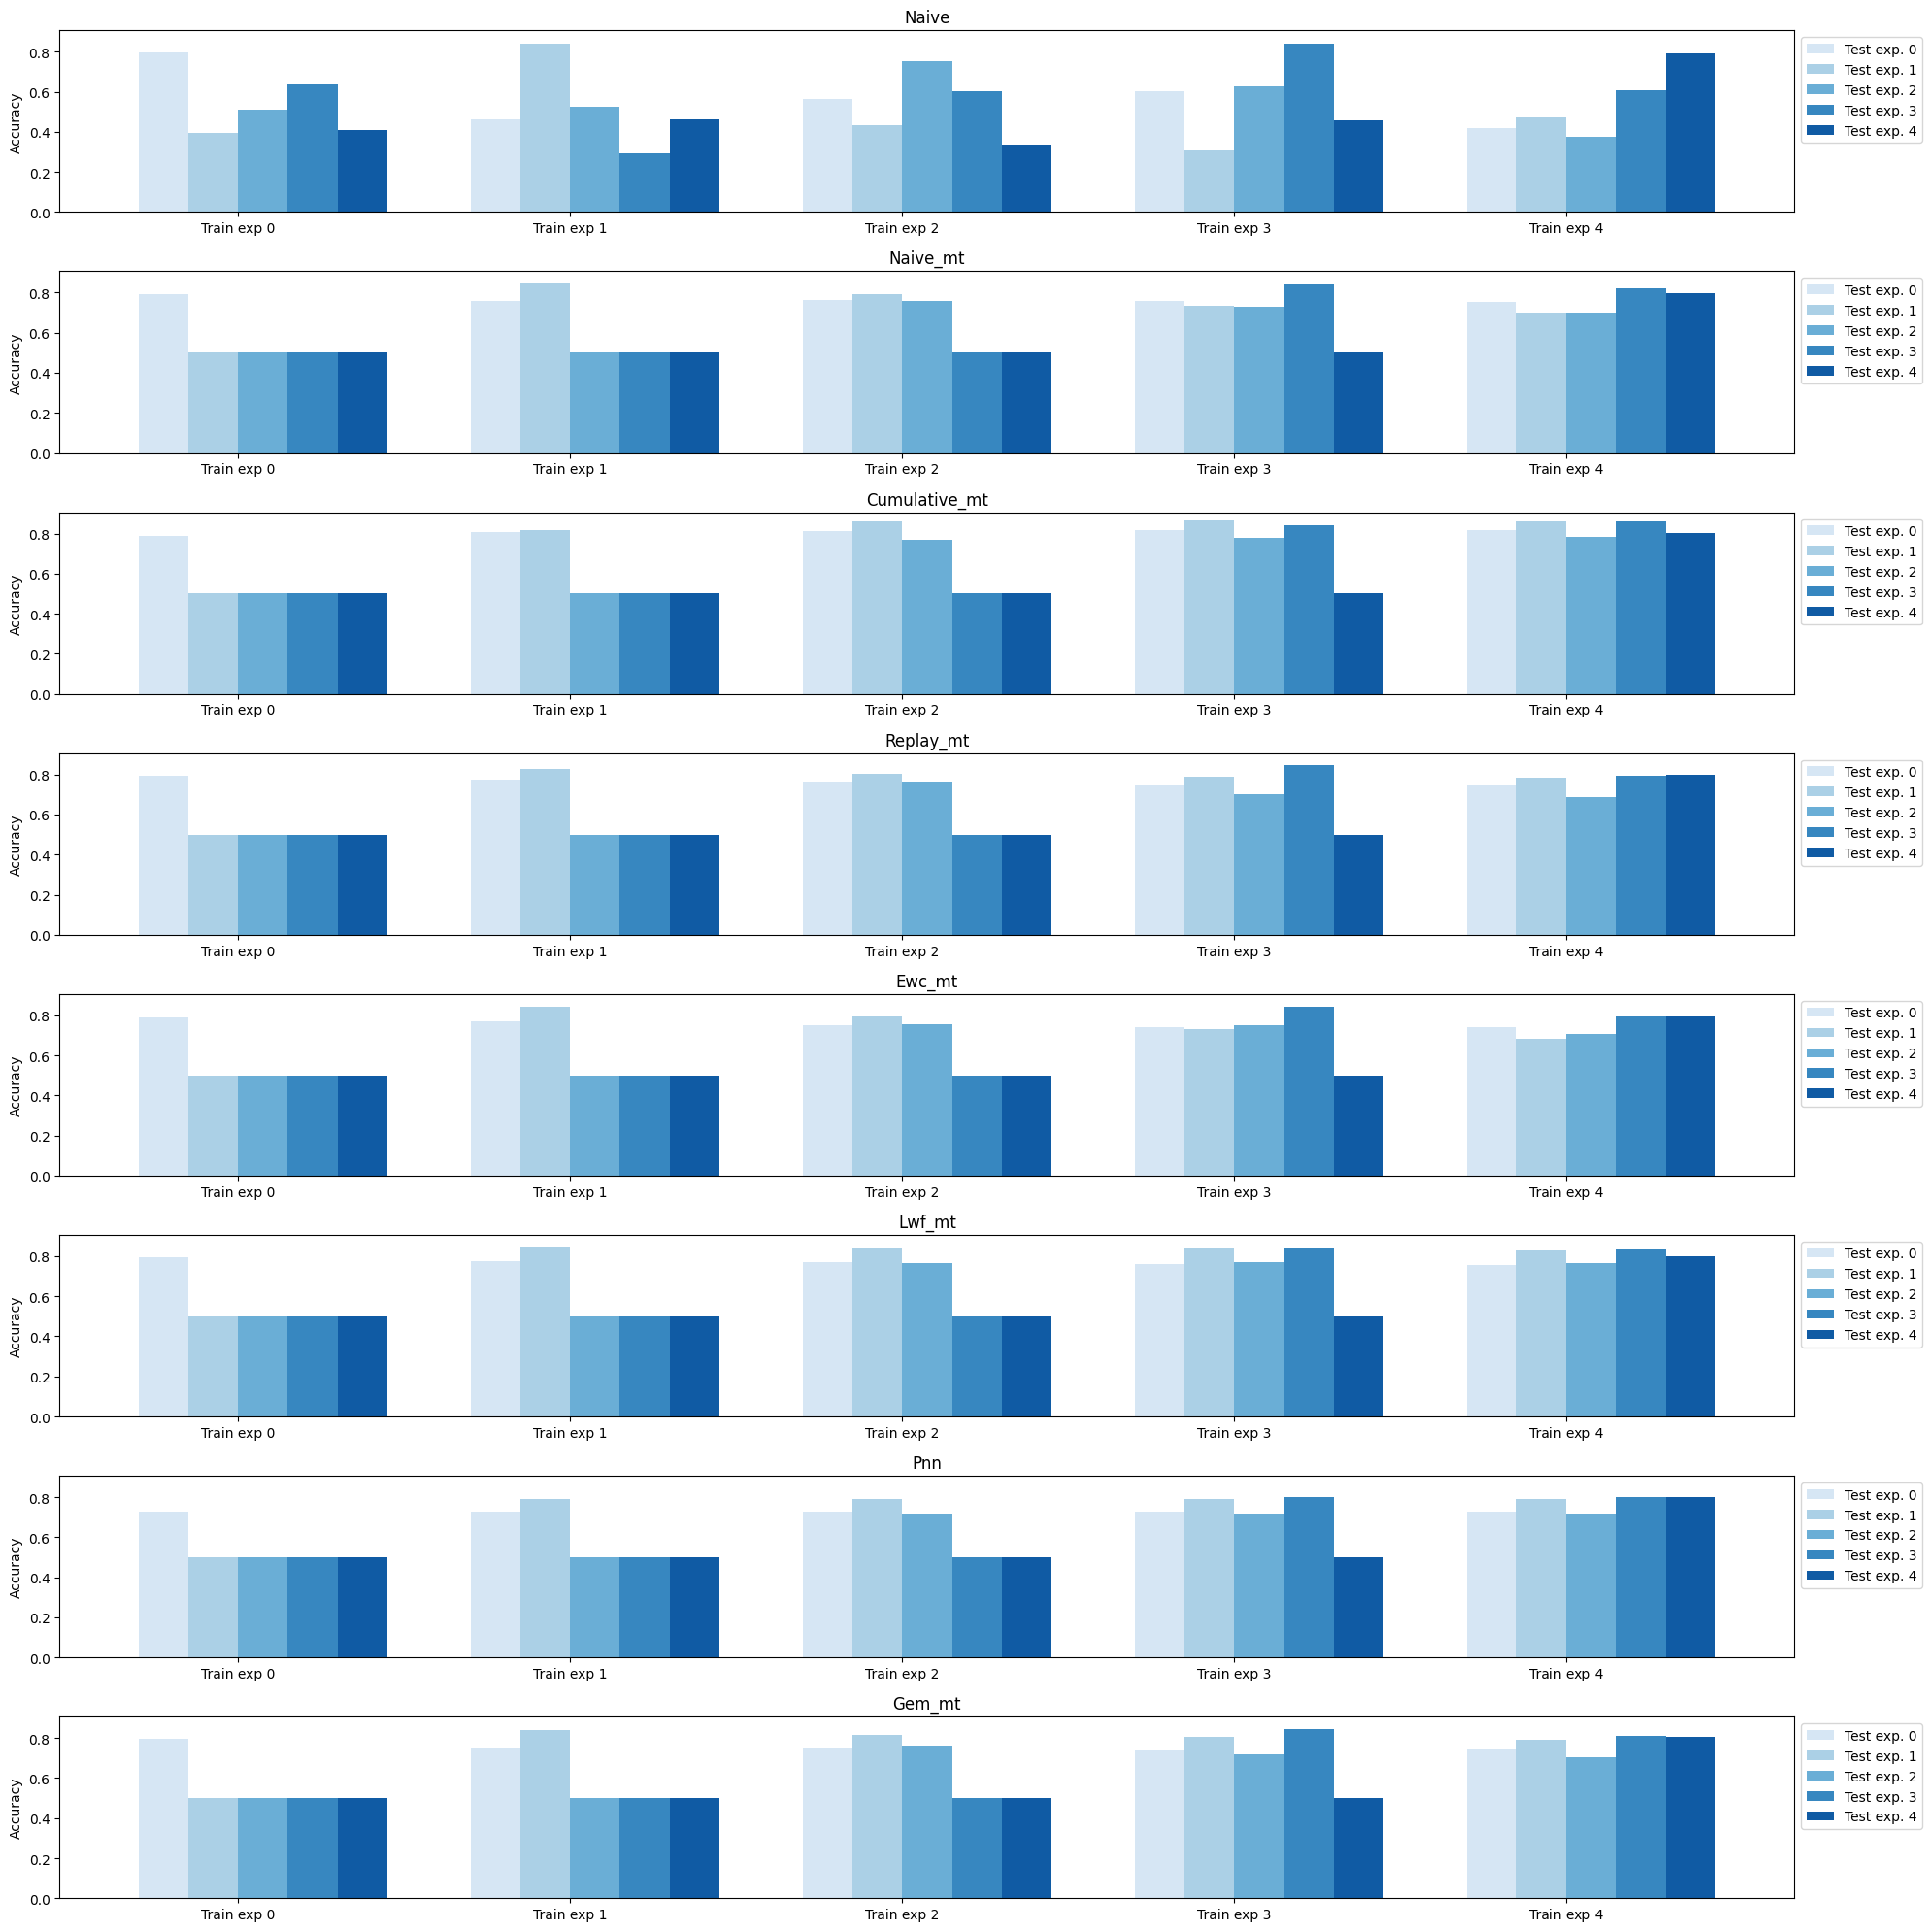

In [ ]:
fontsize=10
plt.rcParams.update({'font.size': fontsize})
fig, ax = plt.subplots(figsize=(2.5*len(perf.keys()),20), nrows=len(strategies), ncols=1, sharey=True)
for i, strategy in enumerate(strategies):
  plot_strategy_accs(strategy, perf, ax[i])
plt.tight_layout()

From this plot is difficult to have a global view of the different strategies' performance.

Let's see each metric in detail...

## Accuracy Trend on the experiences seen so far

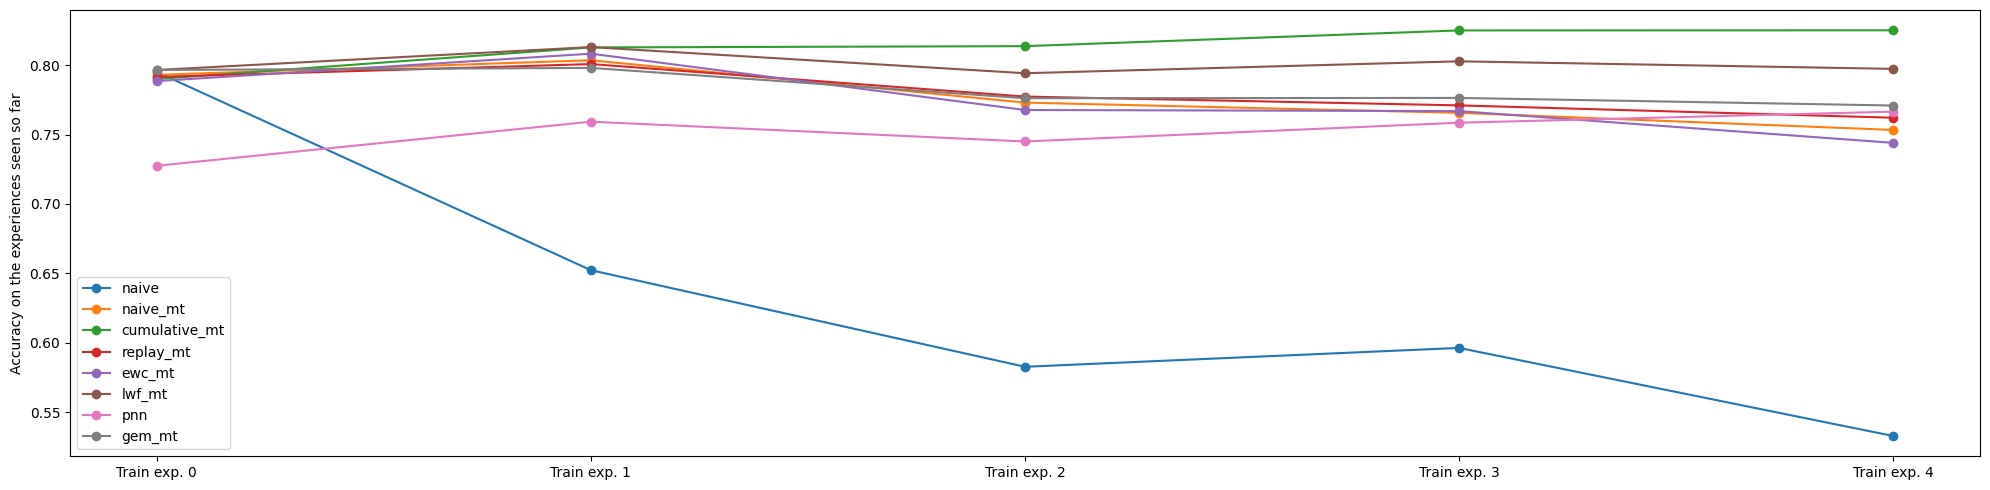

In [ ]:
fig, ax = plt.subplots(figsize=(20,5), nrows=1, ncols=1)
for strategy in perf:
  accs = [np.mean(perf[strategy]["accuracies"][i][:i+1]) for i in range(len(perf[strategy]["accuracies"]))]
  ax.plot(accs, label=strategy, marker="o")
ax.set_xticks(ticks=np.arange(len(accs)), labels=[f"Train exp. {i}" for i in range(N_EXP)])
ax.set_ylabel("Accuracy on the experiences seen so far")
ax.legend()
plt.tight_layout()

From this plot is difficult to undersand the difference between the strategies, since Naive perform bad.

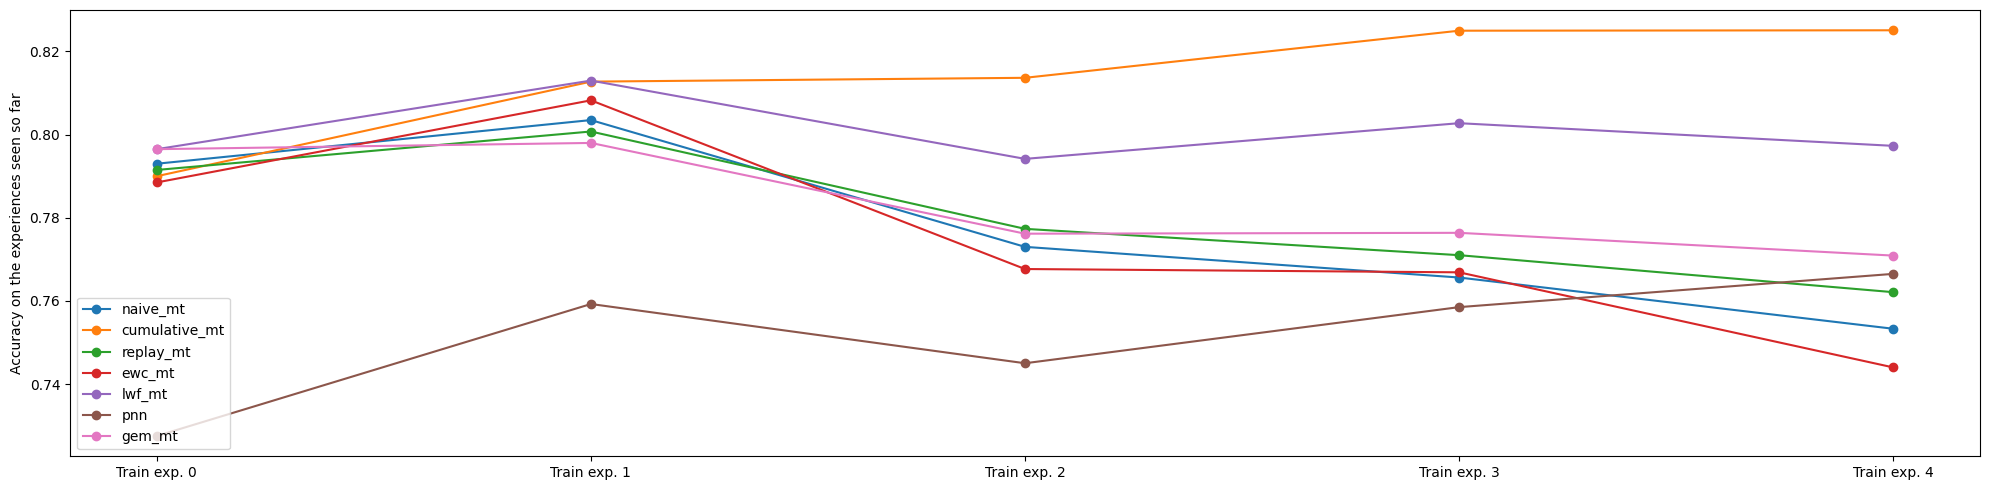

In [ ]:
fig, ax = plt.subplots(figsize=(20,5), nrows=1, ncols=1)
for strategy in perf:
  if strategy=="naive":
    continue
  accs = [np.mean(perf[strategy]["accuracies"][i][:i+1]) for i in range(len(perf[strategy]["accuracies"]))]
  ax.plot(accs, label=strategy, marker="o")
ax.set_xticks(ticks=np.arange(len(accs)), labels=[f"Train exp. {i}" for i in range(N_EXP)])
ax.set_ylabel("Accuracy on the experiences seen so far")
ax.legend()
plt.tight_layout()

*   As expected, Cumulative is the best-performing strategy. However, it's not appliable in the reality since it trains the model on the training sets of all the experiences seen so far.
*   Excluding Cumulative, LwF is the best-performing strategy. It performs better than the others on the experience seen so far.
*   Multi-Head Naive achieves good performance and can outperform EWC.
*   PNN can outperform Multi-Head Naive only on the last experience.

## Average accuracy and A metric

In [ ]:
import pandas as pd

In [ ]:
df = pd.DataFrame([[strategy, perf[strategy]["a_metric"]] for strategy in strategies], columns=["Strategy", "a_metric"])
df.sort_values("a_metric", ascending=False)

,Strategy,a_metric
2,cumulative_mt,0.818800
5,lwf_mt,0.800167
7,gem_mt,0.778733
3,replay_mt,0.774633
1,naive_mt,0.769867
4,ewc_mt,0.766367
6,pnn,0.756500
0,naive,0.593100


The previous findings are summarized by the A Metric.

In [ ]:
df = pd.DataFrame([[strategy, perf[strategy]["average_accuracy"]] for strategy in strategies], columns=["Strategy", "Acc"])
df.sort_values("Acc", ascending=False)

,Strategy,Acc
2,cumulative_mt,0.8251
5,lwf_mt,0.7973
7,gem_mt,0.7709
6,pnn,0.7665
3,replay_mt,0.7621
1,naive_mt,0.7533
4,ewc_mt,0.7440
0,naive,0.5328


This table reflects the findings of the previous plot on the last experience.

## Backward Transfer

Let's now focus on how the different strategy behaves with respect to the previous learned experiences.

In [ ]:
def plot_strategy_bwts(strategy, perf, ax):
  train_exp = [f"Train exp {i}" for i in range(1, N_EXP)]
  bwt = np.array(perf[strategy]["bwt_exp"])[1:,:]
  bwt[bwt == None] = 0
  values = {f'Test exp. {i}': bwt[:,i] for i in range(N_EXP-1)}

  cmap = plt.cm.Blues
  x = np.arange(len(train_exp))  # the label locations
  width = 0.15  # the width of the bars
  multiplier = 0

  i = 0
  for attribute, measurement in values.items():
      color = cmap((i+1)*(1/(len(values)+1)))
      offset = width * multiplier
      rects = ax.bar(x + offset, measurement, width, label=attribute, color=color)
      multiplier += 1
      i += 1
  ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [0, 0], "k--", color="grey", linewidth=1)

  # Add some text for labels, title and custom x-axis tick labels, etc.
  ax.set_ylabel('Backward Transfer')
  ax.set_xticks(x + 1.5*width, train_exp)
  ax.set_yticks([0], minor=True)
  ax.legend(bbox_to_anchor=(1,1), loc="upper left")
  ax.set_title(strategy.capitalize())

<ipython-input-15-6a4fae6fd045>:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [0, 0], "k--", color="grey", linewidth=1)


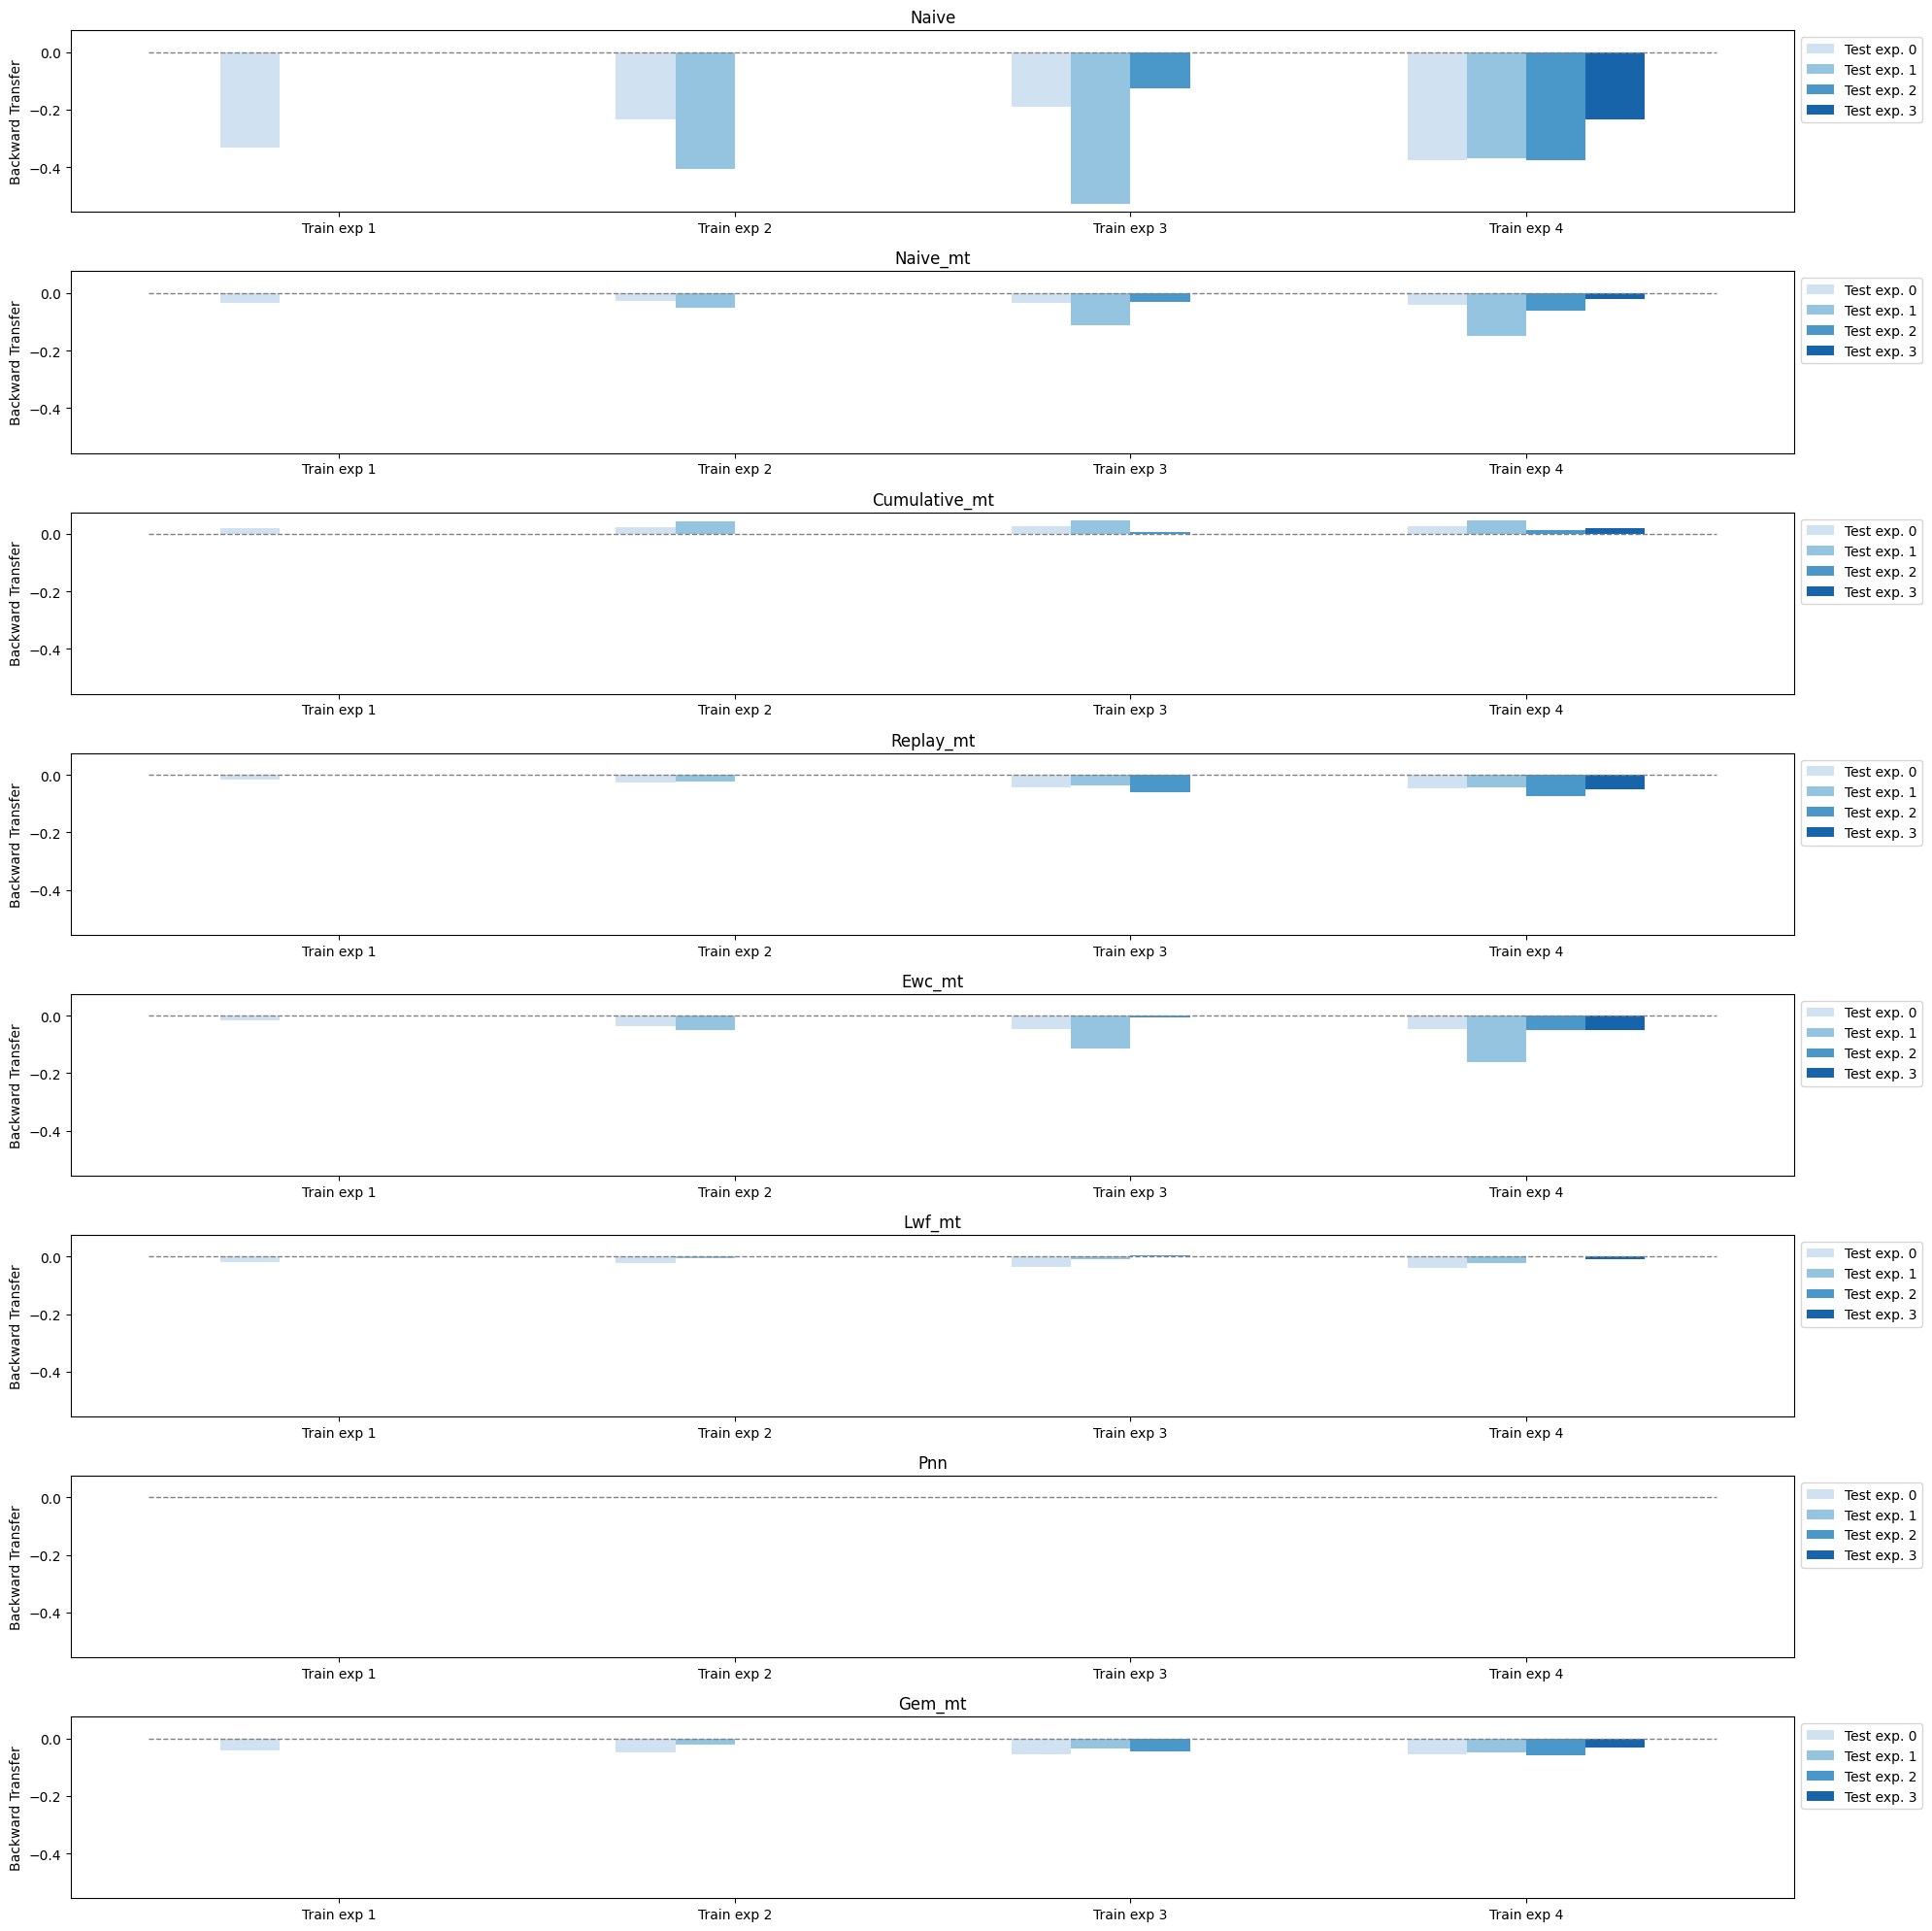

In [ ]:
fig, ax = plt.subplots(figsize=(2.5*len(perf.keys()),20), nrows=len(strategies), ncols=1, sharey=True)
for i, strategy in enumerate(strategies):
  plot_strategy_bwts(strategy, perf, ax[i])
plt.tight_layout()

*   Naive suffers from catastrophic forgetting. It hardly forgets the previpus experiences.
*   PNN and Cumulative are the only strategies that does not suffer from catastrophic forgetting. PNN freezes the weights associated with the previous tasks and add a new column for each new task. Cumulative has positive bwts.
*   The other strategies have a very low catastrophic forgetting.

In [ ]:
df = pd.DataFrame([[strategy, perf[strategy]["bwt"][-1]] for strategy in strategies], columns=["Strategy", "bwt"])
df.sort_values("bwt", ascending=False)

,Strategy,bwt
2,cumulative_mt,0.026375
6,pnn,0.000000
5,lwf_mt,-0.017000
7,gem_mt,-0.048500
3,replay_mt,-0.053750
1,naive_mt,-0.067250
4,ewc_mt,-0.077125
0,naive,-0.338875


The previous findings are confirmed by the final bwt metric. Cumulative is the only strategy that has positive backward transfer (even if is very low).

## Forward Transfer

In [ ]:
def plot_strategy_ftws(strategy, perf, ax):

  x = [f"Train exp {i}" for i in range(N_EXP-1)]
  values = perf[strategy]["fwt_exp"]

  cmap = plt.cm.Blues

  ax.bar(x, values)
  ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [0, 0], "k--", color="grey", linewidth=1)

  # Add some text for labels, title and custom x-axis tick labels, etc.
  ax.set_ylabel('Forward Transfer')
  ax.set_title(strategy.capitalize())

<ipython-input-18-03136a9e87f5>:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [0, 0], "k--", color="grey", linewidth=1)


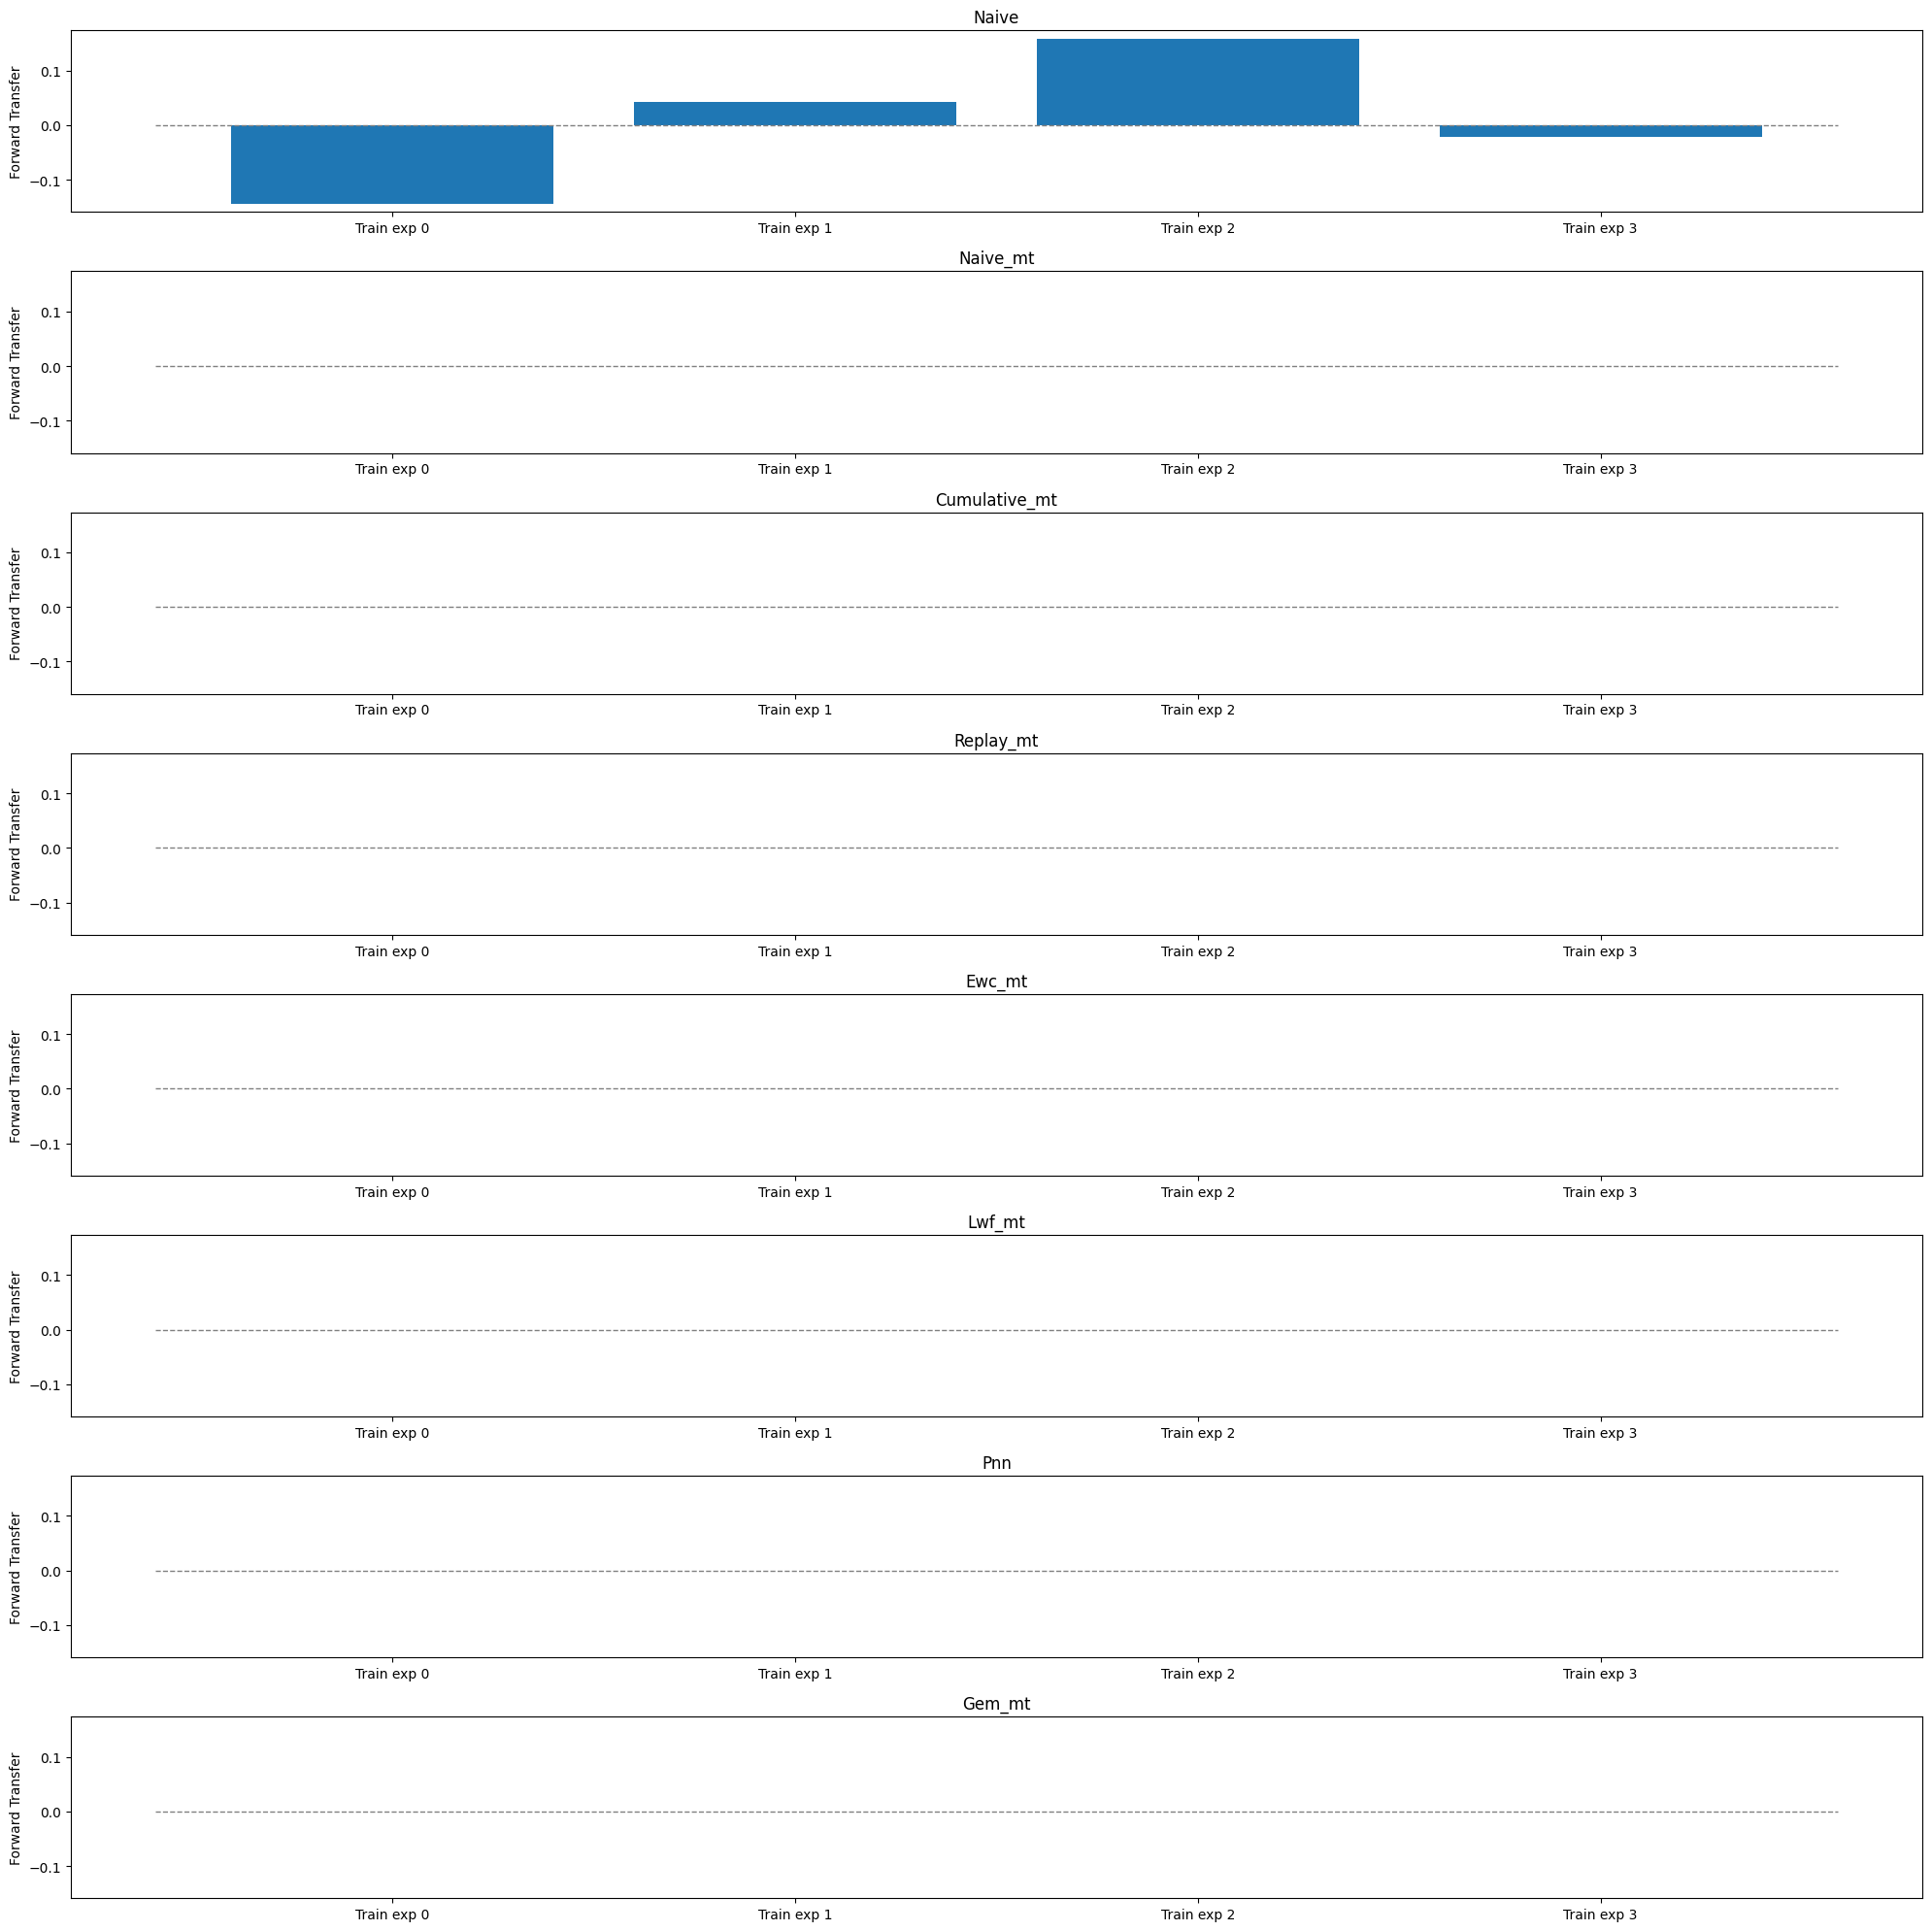

In [ ]:
fig, ax = plt.subplots(figsize=(2.5*len(perf.keys()),20), nrows=len(strategies), ncols=1, sharey=True)
for i, strategy in enumerate(strategies):
  plot_strategy_ftws(strategy, perf, ax[i])
plt.tight_layout()

*   Positive forward transfer is achieved during the training on the second and third experiences by the Naive strategy. On the other experiences the strategy has negative fwt.
*   The other strategy has a fwt equal to 0. Because we are using MultiHead models that random initialize the head of the future tasks.

In [ ]:
df = pd.DataFrame([[strategy, perf[strategy]["fwt"]] for strategy in strategies], columns=["Strategy", "fwt"])
df.sort_values("fwt", ascending=False)

,Strategy,fwt
0,naive,0.009
1,naive_mt,0.000
2,cumulative_mt,0.000
3,replay_mt,0.000
4,ewc_mt,0.000
5,lwf_mt,0.000
6,pnn,0.000
7,gem_mt,0.000


#### Let's now see how the different strategies behave in terms of required resources and time during the training phase.

## RAM usage

In [ ]:
df = pd.DataFrame([[strategy, perf[strategy]["ram"][-1]] for strategy in strategies], columns=["Strategy", "Max RAM Usage"])
df.sort_values("Max RAM Usage", ascending=True)

,Strategy,Max RAM Usage
0,naive,1489.605469
3,replay_mt,1560.367188
1,naive_mt,1562.164062
2,cumulative_mt,1569.222656
4,ewc_mt,1579.324219
5,lwf_mt,1593.203125
7,gem_mt,1743.039062
6,pnn,1760.367188


*   The Naive strategy is the simplest one and, thus, it requires less memory.
*   On the contrary, PNN adds a new base model (a column) each time a new task appears. It therefore requires more memory.
*   GEM is an hybrid strategy between regularization and replay. This results in requiring more memory during training.
*   Replay strategy requires less memory than regularization.

## Time

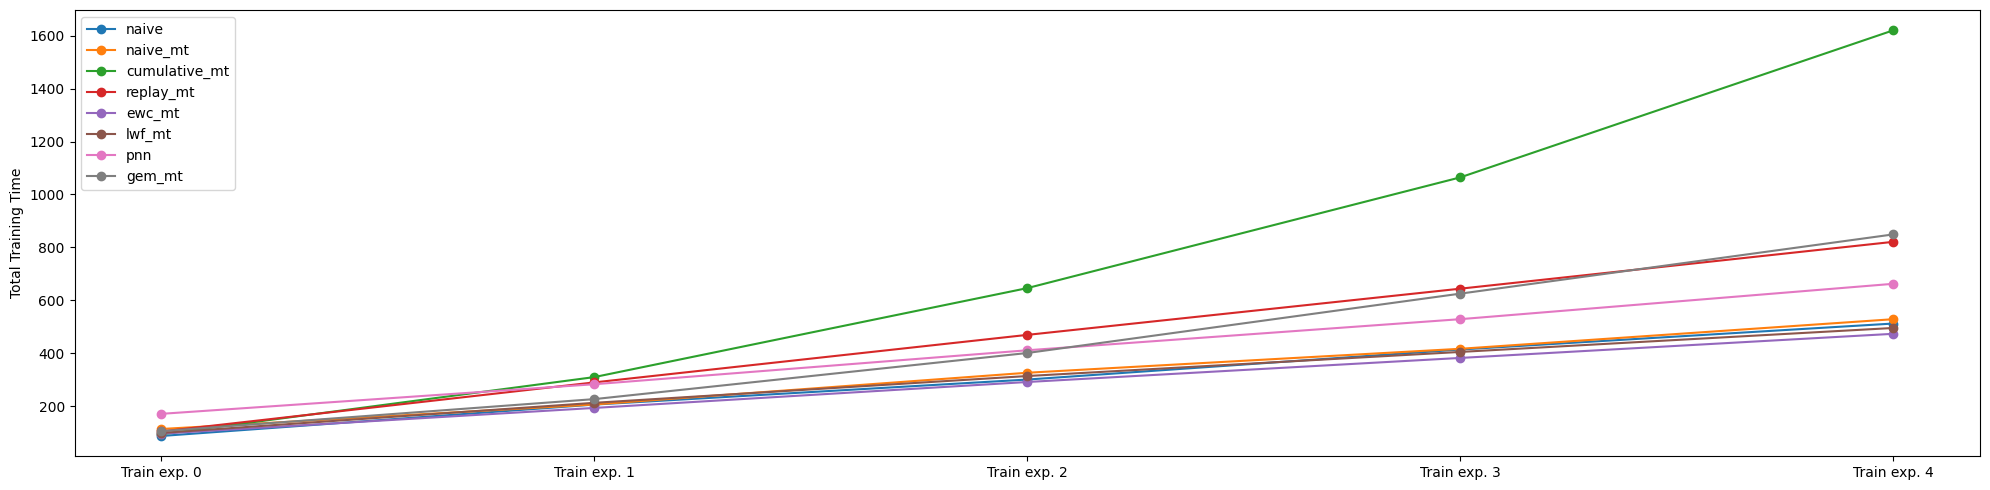

In [ ]:
fig, ax = plt.subplots(figsize=(20,5), nrows=1, ncols=1, sharey=True)
for strategy in perf:
  ax.plot(perf[strategy]["time_cum"], label=strategy, marker="o")
ax.set_xticks(ticks=np.arange(N_EXP), labels=[f"Train exp. {i}" for i in range(N_EXP)])
ax.set_ylabel("Total Training Time")
ax.legend()
plt.tight_layout()

In [ ]:
df = pd.DataFrame([[strategy, perf[strategy]["time_cum"][-1]] for strategy in strategies], columns=["Strategy", "Total Training Time"])
df.sort_values("Total Training Time", ascending=True)

,Strategy,Total Training Time
4,ewc_mt,473.142292
5,lwf_mt,495.213010
0,naive,511.943784
1,naive_mt,528.348275
6,pnn,662.174292
3,replay_mt,820.808931
7,gem_mt,848.923342
2,cumulative_mt,1620.443158


*   Cumulative is the slowest strategy, since the training set size grows linearly with the number of already-seen tasks.
*   Excluding Cumulative, GEM and Replay are the slowest strategies since they are trained on more data.
*   Naive is the simplest strategy and requires less time to be trained. The introduction of multiple heads does not have a huge impact on the training time.
*   In this case, regularization strategies are the slowest.

## Final considerations

The usage of multiple head significantly increase the performance of the strategies.

In this simple case, adding multiple heads to the Naive strategy is enough to achieve good performance. It can also outperform a regularization strategy like EWC.

If it is required to increase the performance, one can use LwF with multiple heads.

Cumulative strategy is the best-performing one but it's not appliable in reality.

The usage of task label simplify the problem.